# Setup

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import importlib
import numpy as np
import pandas as pd
import modellib.io as io
import matplotlib.pyplot as plt

from numpy.linalg import cond
from matrixkit import preconditioning as prec

2024-07-31 17:29:28.867426: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 17:29:28.915603: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 17:29:28.934643: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Load original matrices, true block starts and predicted block starts from CNN and SVB Algorithm

In [2]:
# Reading original test matrices 
test_matrices = np.load('data/matrices/test_matrices_64x64_200.npy')

# Reading block start indicators
_, true_blocks = io.read_from_hdf5('data/datasets/test_dataset_64_200.h5')
cnn_blocks = np.load('data/blockstarts/cnn_predictions.npy')
svb_blocks = np.load('data/blockstarts/svb_predictions_max_16.npy')
gcn_blocks = np.load('data/blockstarts/gcn_predictions.npy')

# Verify Shapes
print(f'Test Matrices Shape: {test_matrices.shape}')
print(f'True Blockstarts Shape: {true_blocks.shape}')
print(f'CNN Predictions Shape: {cnn_blocks.shape}')
print(f'SVB Predictions Shape: {svb_blocks.shape}')
print(f'GCN Predictions Shape: {gcn_blocks.shape}')

Test Matrices Shape: (200, 64, 64)
True Blockstarts Shape: (200, 64)
CNN Predictions Shape: (200, 64)
SVB Predictions Shape: (200, 64)
GCN Predictions Shape: (200, 64)



# Create Preconditioner from true and predicted block starts
### 1. Generate variants of the original matrix data as inversion targets (i.e. 'A' in 'Ax = b')



In [3]:
A_orig = test_matrices
A_norm = prec.prepare_matrix(A_orig, mapping_type='minmax')
A_flip = prec.prepare_matrix(A_orig, mapping_type='flip')
A_flip_norm = prec.prepare_matrix(A_orig, mapping_type='flip_norm')
A_shift = prec.prepare_matrix(A_orig, mapping_type='shift')
A_shift_norm = prec.prepare_matrix(A_orig, mapping_type='shift_norm')

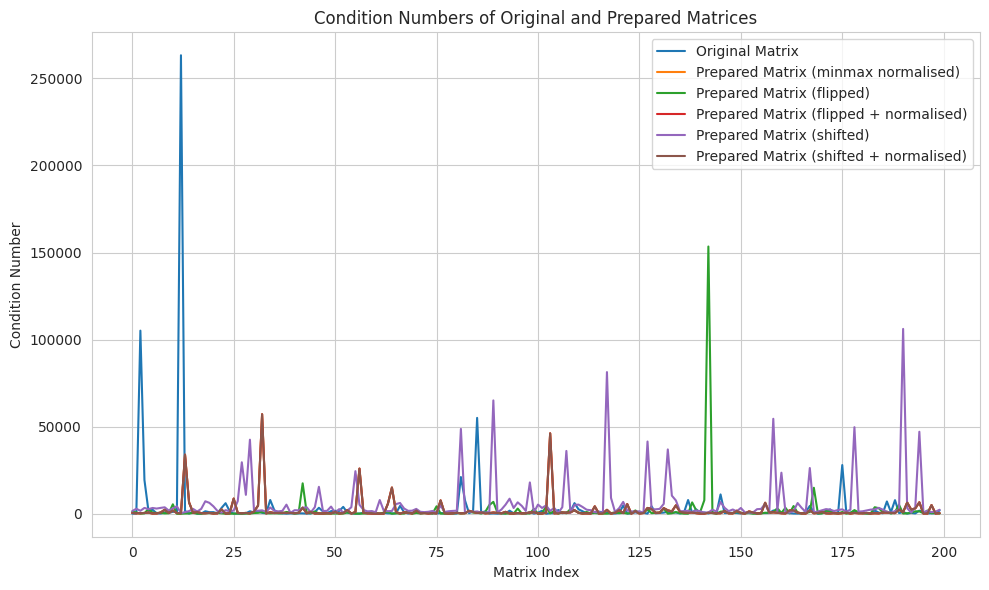

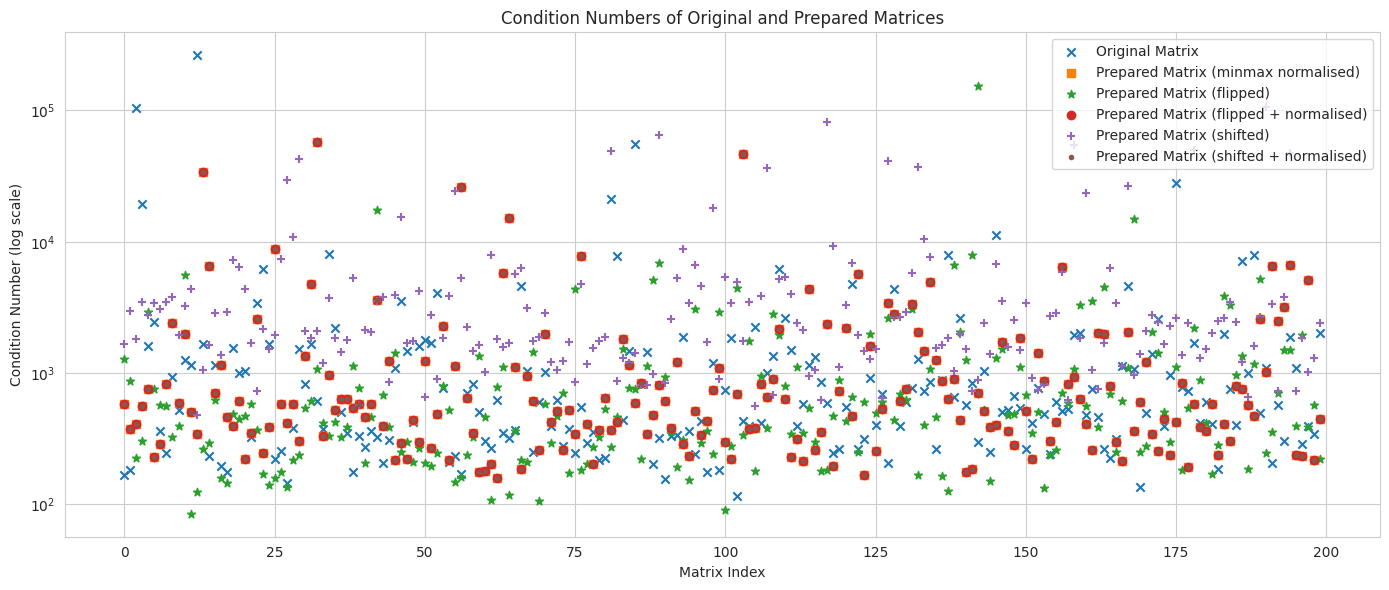

In [9]:
# Calculate condition numbers for each method
def calculate_condition_numbers(matrices):
    return [cond(matrix) for matrix in matrices]

# Calculate condition numbers for each method
cond_orig = calculate_condition_numbers(A_orig)
cond_norm = calculate_condition_numbers(A_norm)
cond_flip = calculate_condition_numbers(A_flip)
cond_flip_norm = calculate_condition_numbers(A_flip_norm)
cond_shift = calculate_condition_numbers(A_shift)
cond_shift_norm = calculate_condition_numbers(A_shift_norm)

# Plot condition numbers
plt.figure(figsize=(10, 6))
plt.plot(cond_orig, label='Original Matrix')
plt.plot(cond_norm, label='Prepared Matrix (minmax normalised)')
plt.plot(cond_flip, label='Prepared Matrix (flipped)')
plt.plot(cond_flip_norm, label='Prepared Matrix (flipped + normalised)')
plt.plot(cond_shift, label='Prepared Matrix (shifted)')
plt.plot(cond_shift_norm, label='Prepared Matrix (shifted + normalised)')
plt.xlabel('Matrix Index')
plt.ylabel('Condition Number')
plt.title('Condition Numbers of Original and Prepared Matrices')
plt.legend()
# plt.yscale('log')  # Added log scale for better visibility
plt.tight_layout()
plt.show()

# Scatterplot 
plt.figure(figsize=(14, 6))
plt.scatter(range(len(cond_orig)), cond_orig, label='Original Matrix', marker='x')
plt.scatter(range(len(cond_norm)), cond_norm, label='Prepared Matrix (minmax normalised)', marker='s')
plt.scatter(range(len(cond_flip)), cond_flip, label='Prepared Matrix (flipped)', marker='*')
plt.scatter(range(len(cond_flip_norm)), cond_flip_norm, label='Prepared Matrix (flipped + normalised)', marker='o')
plt.scatter(range(len(cond_shift)), cond_shift, label='Prepared Matrix (shifted)', marker='+')
plt.scatter(range(len(cond_shift_norm)), cond_shift_norm, label='Prepared Matrix (shifted + normalised)', marker='.')
plt.xlabel('Matrix Index')
plt.ylabel('Condition Number (log scale)')
plt.gca().set_yscale('log')
plt.title('Condition Numbers of Original and Prepared Matrices')
plt.legend()
plt.tight_layout()
plt.show()

In [10]:
# Create a DataFrame for easy plotting and analysis
df = pd.DataFrame({
    'Original': cond_orig,
    'Normalised': cond_norm,
    'Flipped': cond_flip,
    'Flipped + Normalised': cond_flip_norm,
    'Shifted': cond_shift,
    'Shifted + Normalised': cond_shift_norm
})

# Calculate statistics
stats = df.agg(['mean', 'median', 'min', 'max', 'std']).T
stats['improvement'] = (stats['mean'] - stats.loc['Original', 'mean']) / stats.loc['Original', 'mean'] * 100 * -1 # Calculate improvement in percentage

# Print summary statistics
print(stats.to_string())

                             mean       median         min            max           std  improvement
Original              3576.480713   586.016479  115.035286  263269.718750  20455.035156    -0.000000
Normalised            1950.931763   566.987305  159.084396   57215.328125   6088.224609    45.451077
Flipped               1845.928467   471.344482   84.779854  153495.859375  10960.286133    48.387016
Flipped + Normalised  1950.931763   566.987305  159.084396   57215.328125   6088.224609    45.451077
Shifted               6144.447266  2098.647949  476.923065  106196.968750  13482.469727   -71.801498
Shifted + Normalised  1950.931763   566.987305  159.084396   57215.328125   6088.224609    45.451077


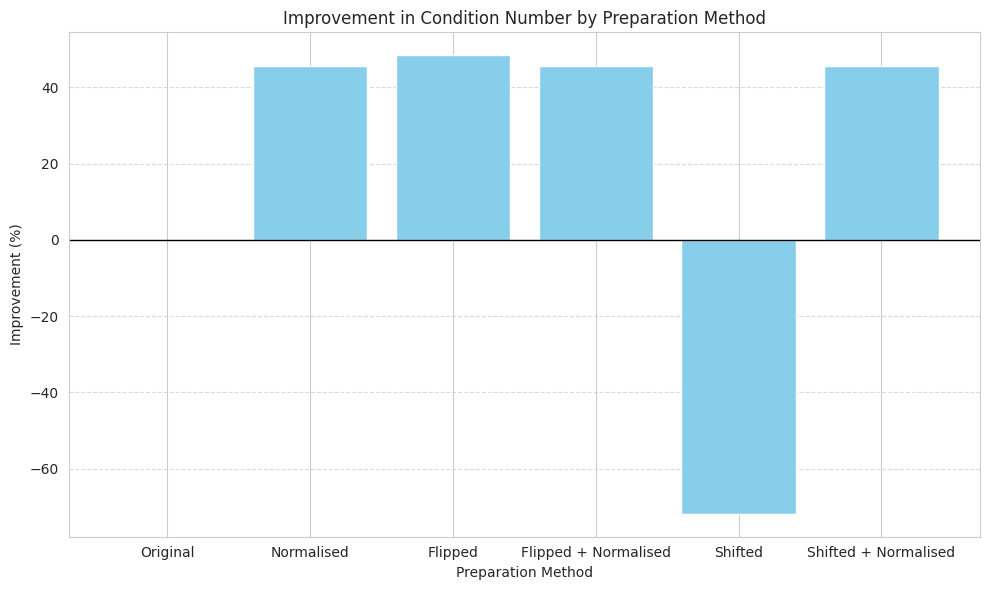

In [13]:
# Plot summary statistics
plt.figure(figsize=(10, 6))
plt.bar(stats.index, stats['improvement'], color='skyblue')
plt.axhline(0, color='black', linewidth=1)
plt.xlabel('Preparation Method')
plt.ylabel('Improvement (%)')
plt.title('Improvement in Condition Number by Preparation Method')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### 2. Invert Blocks (ensure non-singularity)

In [4]:
# Using True block starts from different methods and Matrices (with different preprocessing methods, optional)
precs_true = prec.generate_block_jacobi_preconditioner(A_orig, true_blocks)
precs_cnn = prec.generate_block_jacobi_preconditioner(A_orig, cnn_blocks)
precs_gcn = prec.generate_block_jacobi_preconditioner(A_orig, gcn_blocks)
precs_svb = prec.generate_block_jacobi_preconditioner(A_orig, svb_blocks)

# precs_true_norm = prec.generate_block_jacobi_preconditioner(A_norm, true_blocks)
# precs_true_flip = prec.generate_block_jacobi_preconditioner(A_flip, true_blocks)
# precs_true_flip_norm = prec.generate_block_jacobi_preconditioner(A_flip_norm, true_blocks)
# precs_true_shift_norm = prec.generate_block_jacobi_preconditioner(A_shift_norm, true_blocks)

b = np.ones((test_matrices.shape[0], A_orig.shape[1]))

# Run GMRES Solver:
### With and Without Preconditioner from True Block Starts
    - With original Matrices
    - With normalised Matrices
    - With flipped Matrices
    - With flipped and normalised Matrices
    - With shifted Matrices
    - With shifted and normalised Matrices


Solving Original Matrices with No Preconditioner
Solving Original Matrices with Prec from True Block Starts
Solving Original Matrices with Prec from CNN Block Starts
Solving Original Matrices with Prec from GCN Block Starts
Solving Original Matrices with Prec from SVB Block Starts
      Matrix Type         Preconditioner Type  Converged  Total Systems  Percent Converged  Mean Iterations  Median Iterations  Max Iterations  Min Iterations
Original Matrices           No Preconditioner        181            200               90.5      2566.977901             1700.0           10381             168
Original Matrices Prec from True Block Starts        190            200               95.0       262.615789              111.0            3632              20
Original Matrices  Prec from CNN Block Starts        184            200               92.0       258.211957              107.0            5116              19
Original Matrices  Prec from GCN Block Starts        176            200           

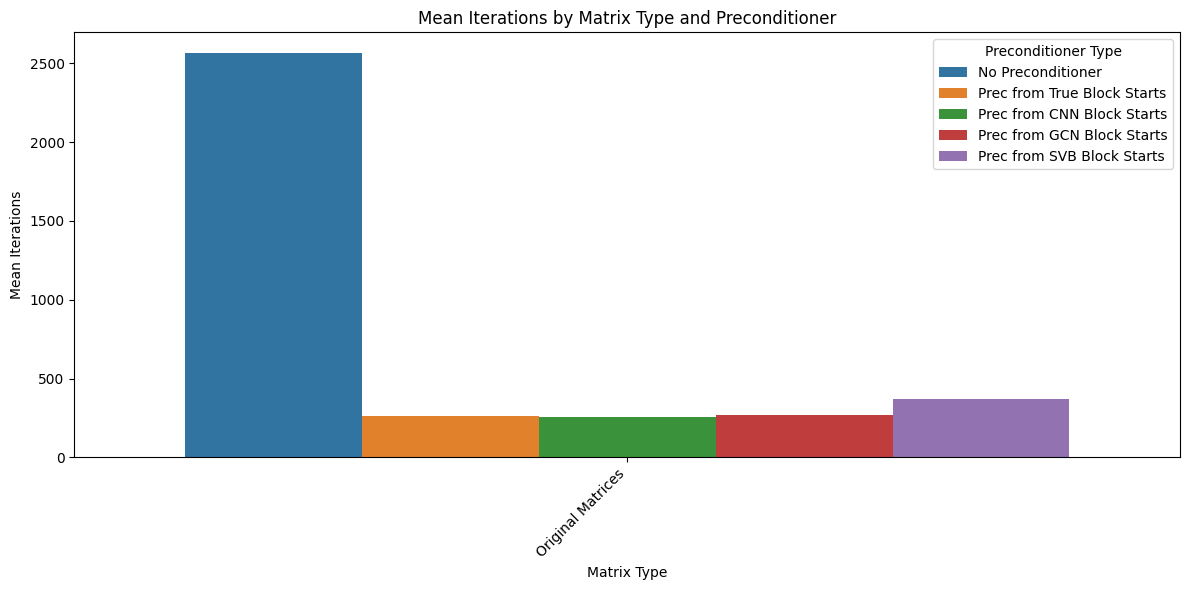

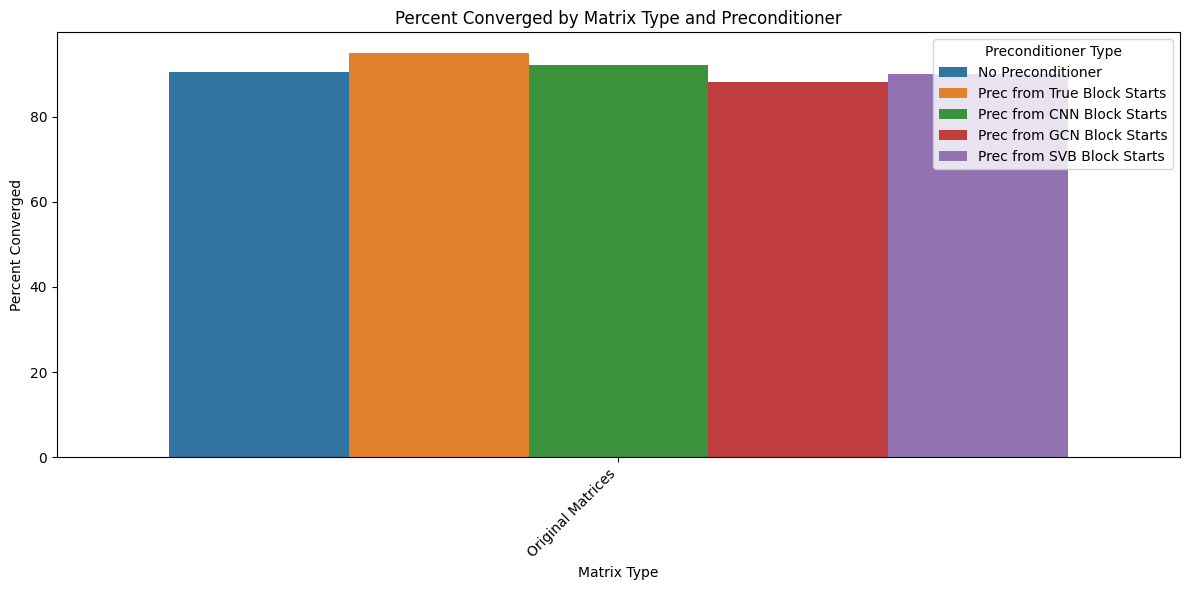

In [9]:
# Run GMRES experiments with different preconditioners
input_matrices_list = [
    ('Original Matrices', A_orig)
]
    # ('Normalised Matrices', A_norm),
    # ('Flipped Matrices', A_flip),
    # ('Flipped and Normalised Matrices', A_flip_norm),
    # ('Shifted Matrices', A_shift),
    # ('Shifted and Normalised Matrices', A_shift_norm)


preconditioners_list = [
    ('No Preconditioner', None),
    ('Prec from True Block Starts', precs_true),
    ('Prec from CNN Block Starts', precs_cnn),
    ('Prec from GCN Block Starts', precs_gcn),
    ('Prec from SVB Block Starts', precs_svb)    
]



def run_gmres_experiments(input_matrices_list, preconditioners_list, b):
    results = []

    for input_name, input_matrices in input_matrices_list:
        for prec_name, preconditioner_source in preconditioners_list:
            print(f'Solving {input_name} with {prec_name}...')
            x, info, iters, residuals = prec.solve_with_gmres_monitored(input_matrices, b, preconditioner_source)

            converged = np.sum(info == 0)
            total_systems = len(info)
            percent_converged = (converged / total_systems) * 100

            iters_converged = [iters[i] for i in range(total_systems) if info[i] == 0]
            
            results.append({
                'Matrix Type': input_name,
                'Preconditioner Type': prec_name,
                'Converged': converged,
                'Total Systems': total_systems,
                'Percent Converged': percent_converged,
                'Mean Iterations': np.mean(iters_converged),
                'Median Iterations': np.median(iters_converged),
                'Max Iterations': np.max(iters_converged),
                'Min Iterations': np.min(iters_converged)
            })

    return pd.DataFrame(results)

results_df = run_gmres_experiments(input_matrices_list, preconditioners_list, b)
prec.print_results_table(results_df)
prec.plot_results(results_df)

## Compare Results

In [12]:
pd.set_option("display.precision", 2)
results_df

,Matrix Type,Preconditioner Type,Converged,Total Systems,Percent Converged,Mean Iterations,Median Iterations,Max Iterations,Min Iterations
0,Original Matrices,No Preconditioner,181,200,90.5,2566.98,1700.0,10381,168
1,Original Matrices,Prec from True Block Starts,190,200,95.0,262.62,111.0,3632,20
2,Original Matrices,Prec from CNN Block Starts,184,200,92.0,258.21,107.0,5116,19
3,Original Matrices,Prec from GCN Block Starts,176,200,88.0,271.42,109.5,3756,16
4,Original Matrices,Prec from SVB Block Starts,180,200,90.0,368.43,119.5,5740,19
